**Model to Predict NYC's Yellow Taxi Trips and Ride Durations**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
import tensorflow_data_validation as tfdv

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [ ]:
jan2020_taxis = pd.read_parquet('yellow_tripdata_2020-01.parquet', engine = 'fastparquet')
jan2020_taxis = jan2020_taxis.drop(['RatecodeID', 'store_and_fwd_flag', 'airport_fee'], axis = 1)
jan2020_taxis.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,238,239,1,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5
1,1,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,239,238,1,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5
2,1,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,238,238,1,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5
3,1,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,238,151,1,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0
4,2,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0


**Downloading climate data: while at the Meteostat portal, select ‘location’ (New York, Wall Street) and ‘date range’ (01/01/2020 to 01/31/2020). Note: the default ‘date range’ will be the current week.**

https://meteostat.net/en/place/us/financial-district?s=KJRB0&t=2020-01-01/2020-01-31

In [ ]:
climatic_data = pd.read_csv('export.csv')

# temperature in Celsius for 01/01/2020 to 01/31/2020

In [ ]:
climatic_data = climatic_data.drop(columns = ['prcp', 'snow', 'wdir', 'wpgt', 'tsun'], axis = 1)
climatic_data['date'] = pd.to_datetime(climatic_data.date, format = '%Y-%m-%d')
climatic_data.head()

,date,tavg,tmin,tmax,wspd,pres
0,2020-01-01,3.6,1.7,5.0,17.3,1008.2
1,2020-01-02,4.7,0.6,8.9,12.4,1013.9
2,2020-01-03,7.6,6.7,8.3,8.4,1010.2
3,2020-01-04,8.2,6.7,9.4,5.7,1003.7
4,2020-01-05,4.6,2.8,7.2,8.2,1010.1


In [ ]:
climatic_data['y_day'] = climatic_data.date.dt.dayofyear
jan2020_taxis['y_day'] = jan2020_taxis.tpep_pickup_datetime.dt.dayofyear

In [ ]:
jan2020_taxis['ride_in_mins'] = pd.Series(map(lambda x: (x.seconds) / 60, (jan2020_taxis['tpep_dropoff_datetime'] - jan2020_taxis['tpep_pickup_datetime'])))

In [ ]:
jan2020_taxi_weather = pd.merge(jan2020_taxis, climatic_data, on = 'y_day')
jan2020_taxi_weather = jan2020_taxi_weather.drop(columns = ['date'], axis = 1)
jan2020_taxi_weather.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,...,improvement_surcharge,total_amount,congestion_surcharge,y_day,ride_in_mins,tavg,tmin,tmax,wspd,pres
0,1,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,238,239,1,6.0,3.0,...,0.3,11.27,2.5,1,4.800000,3.6,1.7,5.0,17.3,1008.2
1,1,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,239,238,1,7.0,3.0,...,0.3,12.30,2.5,1,7.416667,3.6,1.7,5.0,17.3,1008.2
2,1,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,238,238,1,6.0,3.0,...,0.3,10.80,2.5,1,6.183333,3.6,1.7,5.0,17.3,1008.2
3,1,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,238,151,1,5.5,0.5,...,0.3,8.16,0.0,1,4.850000,3.6,1.7,5.0,17.3,1008.2
4,2,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,193,193,2,3.5,0.5,...,0.3,4.80,0.0,1,2.300000,3.6,1.7,5.0,17.3,1008.2


**Analysis**

In [ ]:
j2020_tw = jan2020_taxi_weather.copy()

j2020_tw = j2020_tw.dropna()
j2020_tw.shape

(5552948, 23)

In [ ]:
j2020_tw['tpep_pickup_datetime'] = pd.to_numeric(j2020_tw['tpep_pickup_datetime'])
j2020_tw['tpep_dropoff_datetime'] = pd.to_numeric(j2020_tw['tpep_dropoff_datetime'])

In [ ]:
X = j2020_tw.drop(['ride_in_mins'], axis = 1)
y = j2020_tw['ride_in_mins']

In [ ]:
# Split dataset into training and validation datasets in 80% / 20% ratio

X = j2020_tw.iloc[:, : -1].values
y = j2020_tw.iloc[:, -1].values

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
scaler = StandardScaler(copy = False)
scaler.fit(X)
scaler.transform(X)

array([[-1.42569855, -1.3771458 , -1.37778506, ...,  0.09575761,
        -0.67654595,  1.81471315],
       [-1.42569855, -1.37671596, -1.37720322, ...,  0.09575761,
        -0.67654595,  1.81471315],
       [-1.42569855, -1.37601698, -1.37657588, ...,  0.09575761,
        -0.67654595,  1.81471315],
       ...,
       [ 0.70141055,  1.21215262,  1.21217711, ...,  0.23115362,
        -0.37075021, -0.84477601],
       [ 0.70141055,  1.21331436,  1.21295257, ...,  0.23115362,
        -0.37075021, -0.84477601],
       [ 0.70141055,  1.2118767 ,  1.21101731, ...,  0.23115362,
        -0.37075021, -0.84477601]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4442358, 22)
(1110590, 22)
(4442358,)
(1110590,)


**EDA**

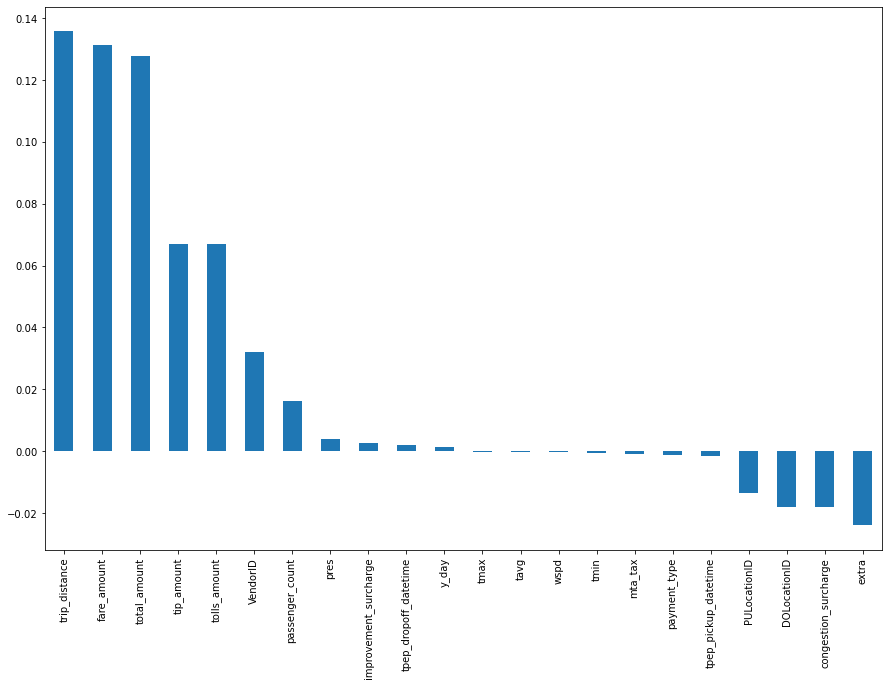

In [ ]:
plt.figure(figsize = (15, 10))
j2020_tw.corr()['ride_in_mins'].sort_values(ascending = False)[1:].plot(kind = 'bar');

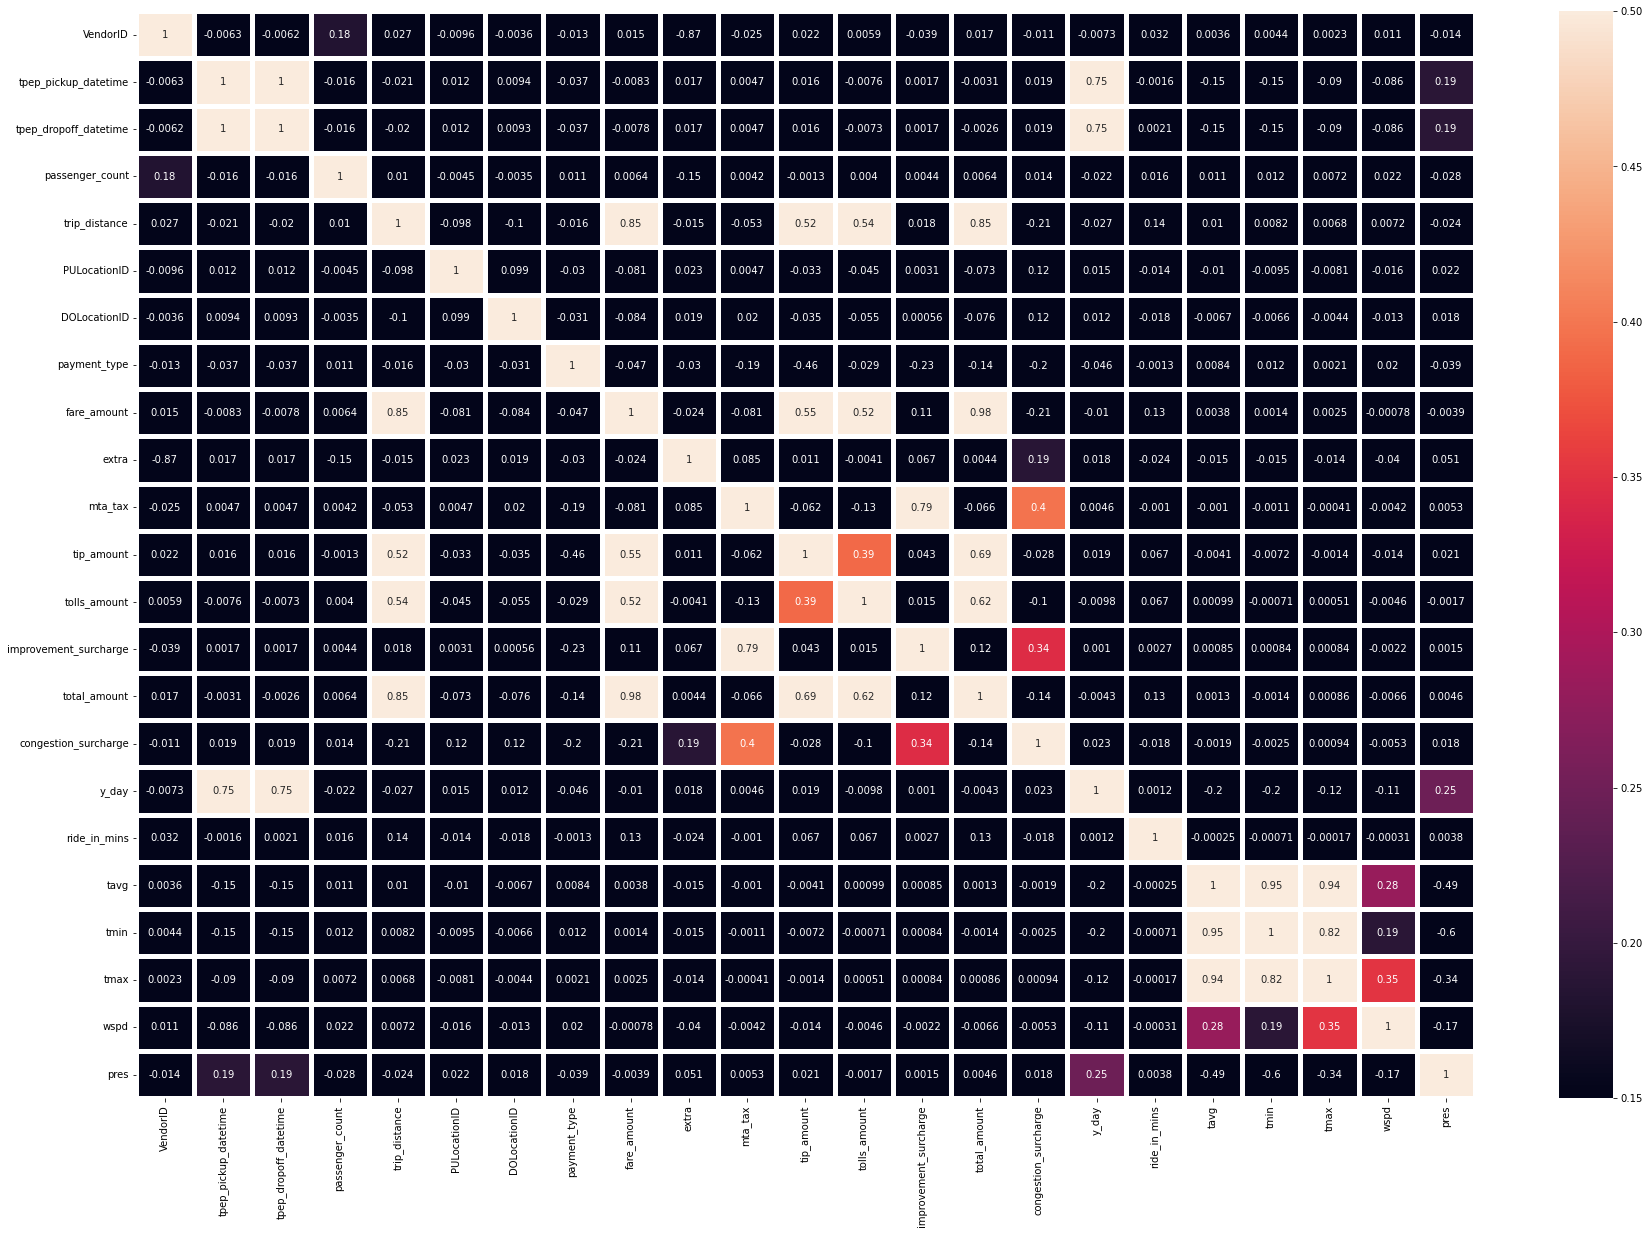

In [ ]:
plt.figure(figsize = (30, 20))
sns.heatmap(j2020_tw.corr(),
            linewidths = 5, vmin = 0.15, vmax = 0.5, annot = True)
plt.yticks(rotation = 0);

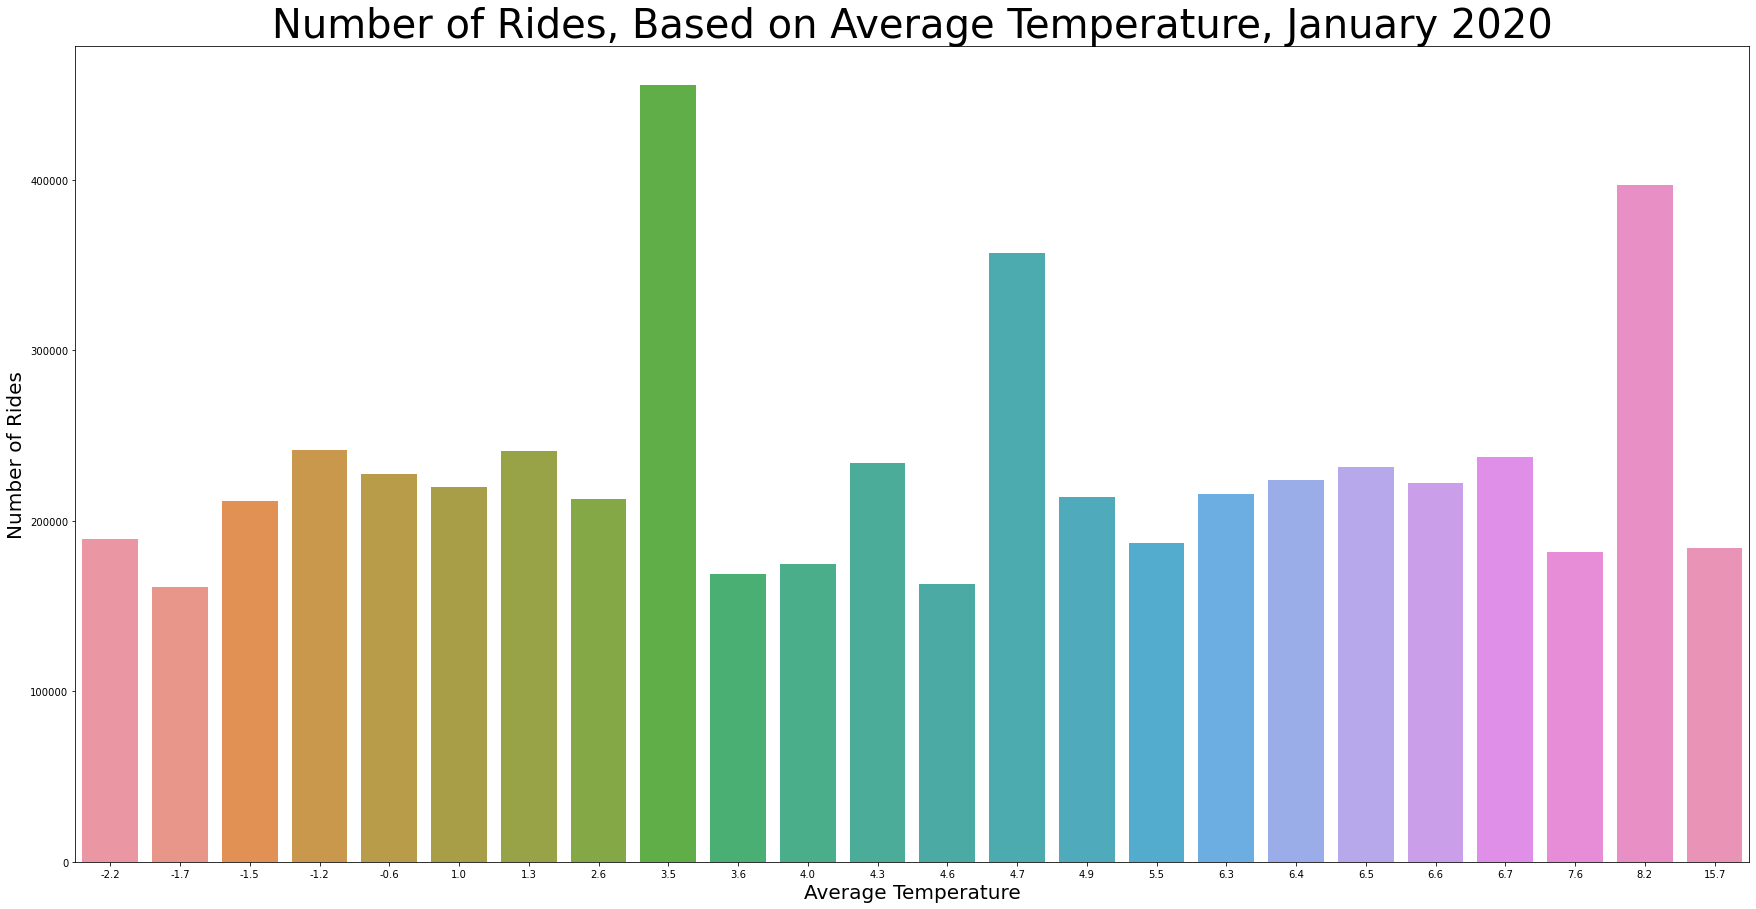

In [ ]:
values = j2020_tw['tavg'].value_counts().index
frequencies = j2020_tw['tavg'].value_counts().values

fig = plt.figure(figsize = (30, 15))

sns.barplot(values, frequencies)
plt.xlabel('Average Temperature', fontsize = 20)
plt.ylabel('Number of Rides', fontsize = 20)
plt.title('Number of Rides, Based on Average Temperature, January 2020', fontsize = 40)

plt.show()

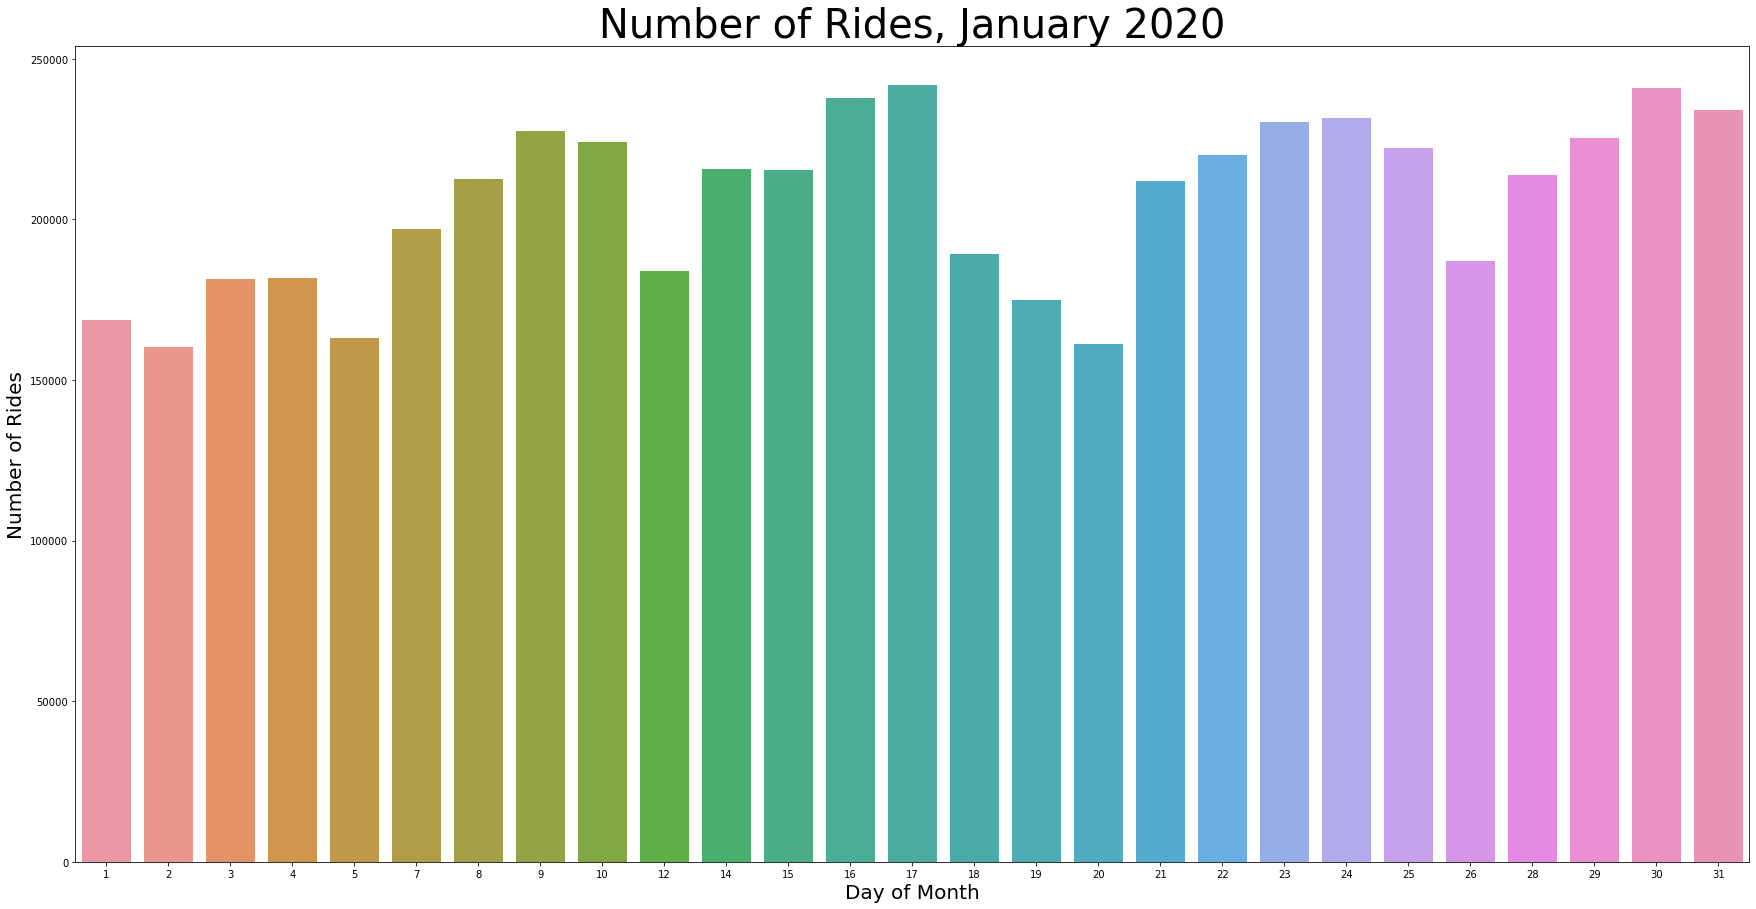

In [ ]:
values = j2020_tw['y_day'].value_counts().index
frequencies = j2020_tw['y_day'].value_counts().values

fig = plt.figure(figsize = (30, 15))

sns.barplot(values, frequencies)
plt.xlabel('Day of Month', fontsize = 20)
plt.ylabel('Number of Rides', fontsize = 20)
plt.title('Number of Rides, January 2020', fontsize = 40)

plt.show()

In [ ]:
train_stats = tfdv.generate_statistics_from_dataframe(j2020_tw)

tfdv.visualize_statistics(train_stats)

**Performing regression modeling analysis on the ready-to-be-fed data into the following Neural Network based algorithms.**

MLP (Multi-Layer Perceptron)

In [ ]:
mlp = MLPRegressor(hidden_layer_sizes = (150, 100, 50), max_iter = 5, activation = 'relu', solver = 'adam',
                   random_state = 5, verbose = True)

mlp.fit(X_train, y_train)

Iteration 1, loss = 2590.67830931
Iteration 2, loss = 10.90968348
Iteration 3, loss = 5.67983479
Iteration 4, loss = 4.75840398
Iteration 5, loss = 3.94906373


MLPRegressor(hidden_layer_sizes=(150, 100, 50), max_iter=5, random_state=5,
             verbose=True)

In [ ]:
y_pred = mlp.predict(X_test)

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df.head(10)

,Actual,Predicted
0,1020.9,1021.552529
1,1015.1,1014.775632
2,1024.2,1021.652313
3,1008.2,1001.017180
4,1016.2,1017.234363
5,1016.2,1009.744948
6,1031.3,1033.759294
7,1013.9,1010.373152
8,1034.5,1030.740778
9,1015.1,1014.208056


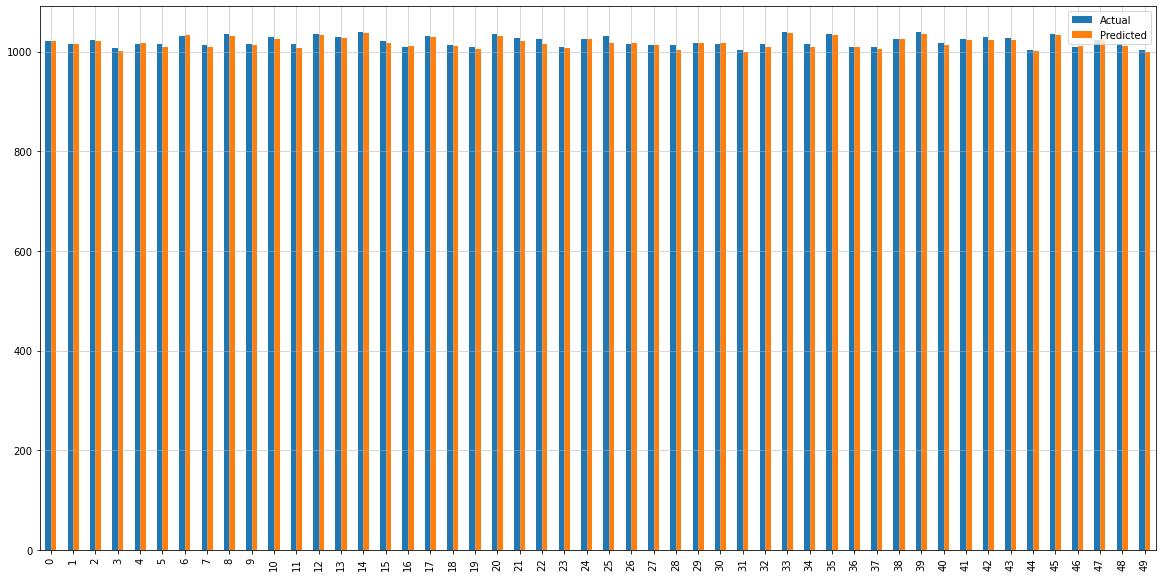

In [ ]:
df = df.head(50)
df.plot(kind = 'bar', figsize = (20, 10))
plt.grid(which = 'major', linestyle = '-', linewidth = '0.5')
plt.grid(which = 'minor', linestyle = ':', linewidth = '0.5')
plt.show()

In [ ]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y_pred))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_absolute_error(y_test, y_pred)))

Mean Absolute Error (MAE): 3.3529662178682957
Mean Squared Error (MSE): 24.134637563481544
Mean Absolute Percentage Error (MAPE): 0.0032860398593403256
Root Mean Squared Error (RMSE): 1.831110651454001


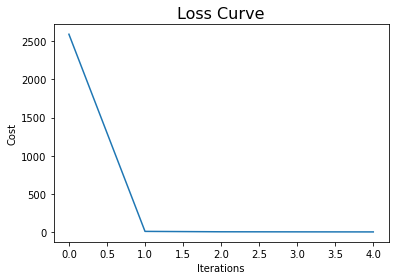

In [ ]:
plt.plot(mlp.loss_curve_)
plt.title('Loss Curve', fontsize = 16)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

**Linear Regression (TF / Keras Sequential Model) with no hidden layers.**

In [ ]:
model = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape = (X.shape[1], ), name = 'InputLayer'),
                            tf.keras.layers.Dense(1, activation = 'linear', name = 'Output')])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Output (Dense)              (None, 1)                 23        
                                                                 
Total params: 23
Trainable params: 23
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = 'tbooards/logs/LinearAdam', histogram_freq = 1)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.05), loss = 'mae',
              metrics = ['mse', 'mae', 'mape', 'accuracy'])

history = model.fit(X_train, y_train, batch_size = 256, epochs = 10, validation_data = (X_test, y_test),
                    shuffle = True, verbose = True, callbacks = [tensorboard_callback])

Epoch 1/10
17353/17353 [==============================] - 27s 1ms/step - loss: 587.4024 - mse: 408131.4375 - mae: 587.4024 - mape: 57.5257 - accuracy: 0.0000e+00 - val_loss: 153.6457 - val_mse: 24010.3340 - val_mae: 153.6457 - val_mape: 15.0427 - val_accuracy: 0.0000e+00
Epoch 2/10
17353/17353 [==============================] - 25s 1ms/step - loss: 18.1046 - mse: 1512.6021 - mae: 18.1046 - mape: 1.7729 - accuracy: 0.0000e+00 - val_loss: 5.4031 - val_mse: 55.6082 - val_mae: 5.4031 - val_mape: 0.5294 - val_accuracy: 0.0000e+00
Epoch 3/10
17353/17353 [==============================] - 25s 1ms/step - loss: 5.3940 - mse: 55.0740 - mae: 5.3940 - mape: 0.5285 - accuracy: 0.0000e+00 - val_loss: 5.3907 - val_mse: 55.6643 - val_mae: 5.3907 - val_mape: 0.5283 - val_accuracy: 0.0000e+00
Epoch 4/10
17353/17353 [==============================] - 25s 1ms/step - loss: 5.3945 - mse: 55.0883 - mae: 5.3945 - mape: 0.5286 - accuracy: 0.0000e+00 - val_loss: 5.4115 - val_mse: 54.9658 - val_mae: 5.4115 - val

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mse,mae,mape,accuracy,val_loss,val_mse,val_mae,val_mape,val_accuracy,epoch
0,587.402405,408131.437500,587.402405,57.525654,0.0,153.645660,24010.333984,153.645660,15.042725,0.0,0
1,18.104568,1512.602051,18.104568,1.772894,0.0,5.403087,55.608196,5.403087,0.529403,0.0,1
2,5.394038,55.073997,5.394038,0.528543,0.0,5.390733,55.664288,5.390733,0.528296,0.0,2
3,5.394467,55.088348,5.394467,0.528586,0.0,5.411515,54.965805,5.411515,0.530307,0.0,3
4,5.394571,55.093479,5.394571,0.528595,0.0,5.407484,54.790470,5.407484,0.529838,0.0,4
5,5.394570,55.068462,5.394570,0.528597,0.0,5.401732,55.308247,5.401732,0.529333,0.0,5
6,5.394198,55.067810,5.394198,0.528557,0.0,5.391580,55.116993,5.391580,0.528241,0.0,6
7,5.394133,55.043251,5.394133,0.528551,0.0,5.400632,55.071533,5.400632,0.529284,0.0,7
8,5.394210,55.047428,5.394210,0.528557,0.0,5.406738,55.036419,5.406738,0.529892,0.0,8
9,5.394495,55.032154,5.394495,0.528587,0.0,5.396614,55.031063,5.396614,0.528852,0.0,9


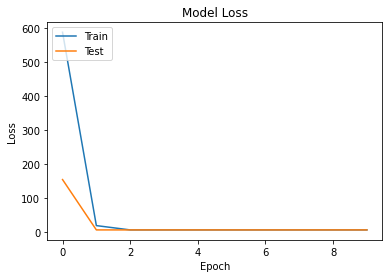

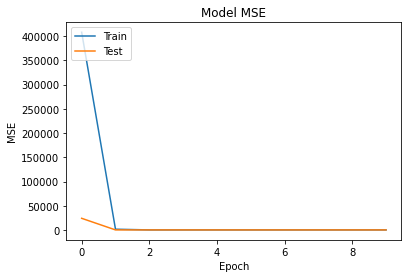

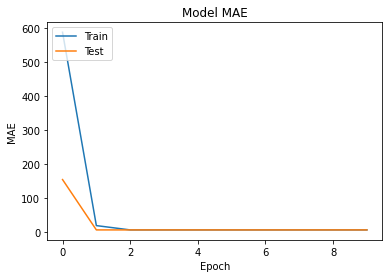

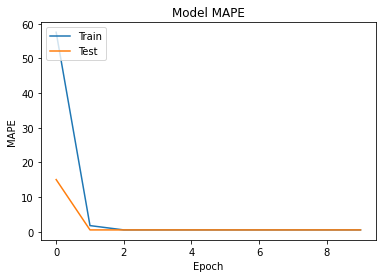

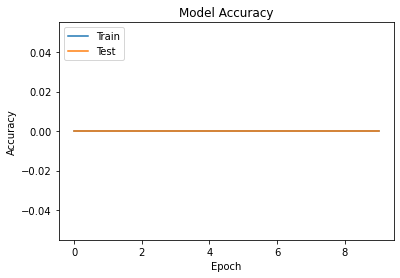

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.title('Model MAPE')
plt.xlabel('Epoch')
plt.ylabel('MAPE')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

In [ ]:
predict = model.evaluate(X_test, y_test)

34706/34706 [==============================] - 42s 1ms/step - loss: 5.3966 - mse: 55.0307 - mae: 5.3966 - mape: 0.5289 - accuracy: 0.0000e+00


In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = 'tbooards/logs/LinearSGD', histogram_freq = 1)

model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 0.05), loss = 'mae',
              metrics = ['mse', 'mae', 'mape', 'accuracy'])

history = model.fit(X_train, y_train, batch_size = 256, epochs = 10, validation_data = (X_test, y_test),
                    shuffle = True, verbose = True, callbacks = [tensorboard_callback])

Epoch 1/10
17353/17353 [==============================] - 37s 2ms/step - loss: 5.3755 - mse: 55.4104 - mae: 5.3755 - mape: 0.5267 - accuracy: 0.0000e+00 - val_loss: 5.3782 - val_mse: 55.3433 - val_mae: 5.3782 - val_mape: 0.5269 - val_accuracy: 0.0000e+00
Epoch 2/10
17353/17353 [==============================] - 26s 2ms/step - loss: 5.3747 - mse: 55.3505 - mae: 5.3747 - mape: 0.5266 - accuracy: 0.0000e+00 - val_loss: 5.3775 - val_mse: 55.3340 - val_mae: 5.3775 - val_mape: 0.5268 - val_accuracy: 0.0000e+00
Epoch 3/10
17353/17353 [==============================] - 25s 1ms/step - loss: 5.3746 - mse: 55.3632 - mae: 5.3746 - mape: 0.5265 - accuracy: 0.0000e+00 - val_loss: 5.3778 - val_mse: 55.4701 - val_mae: 5.3778 - val_mape: 0.5268 - val_accuracy: 0.0000e+00
Epoch 4/10
17353/17353 [==============================] - 25s 1ms/step - loss: 5.3744 - mse: 55.3820 - mae: 5.3744 - mape: 0.5265 - accuracy: 0.0000e+00 - val_loss: 5.3787 - val_mse: 55.4656 - val_mae: 5.3787 - val_mape: 0.5269 - val_a

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mse,mae,mape,accuracy,val_loss,val_mse,val_mae,val_mape,val_accuracy,epoch
0,5.375457,55.410358,5.375457,0.526655,0.0,5.378159,55.343258,5.378159,0.526867,0.0,0
1,5.374725,55.350498,5.374725,0.526553,0.0,5.377491,55.333984,5.377491,0.526841,0.0,1
2,5.374551,55.363232,5.374551,0.526534,0.0,5.377835,55.470062,5.377835,0.526838,0.0,2
3,5.374431,55.381996,5.374431,0.526515,0.0,5.378727,55.465630,5.378727,0.526932,0.0,3
4,5.374255,55.392715,5.374255,0.526497,0.0,5.377913,55.471256,5.377913,0.526862,0.0,4
5,5.374172,55.411667,5.374172,0.526486,0.0,5.376680,55.362782,5.376680,0.526725,0.0,5
6,5.374036,55.421692,5.374036,0.526472,0.0,5.377914,55.487602,5.377914,0.526840,0.0,6
7,5.373910,55.434418,5.373910,0.526459,0.0,5.376256,55.580765,5.376256,0.526676,0.0,7
8,5.373841,55.446739,5.373841,0.526450,0.0,5.378900,55.449879,5.378900,0.526965,0.0,8
9,5.373763,55.456924,5.373763,0.526440,0.0,5.377228,55.613426,5.377228,0.526786,0.0,9


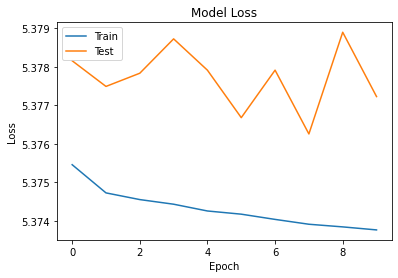

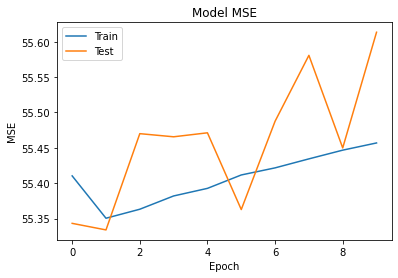

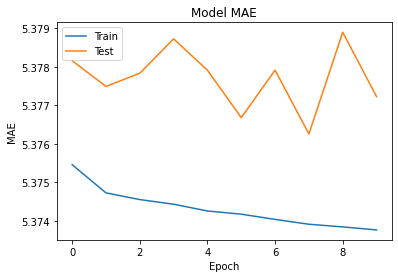

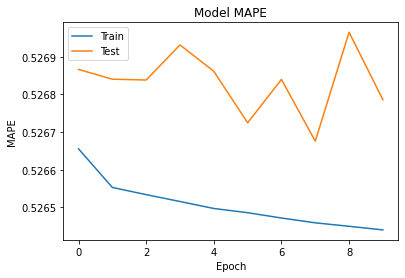

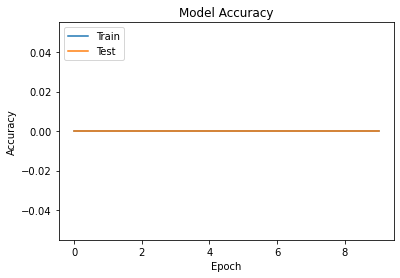

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.title('Model MAPE')
plt.xlabel('Epoch')
plt.ylabel('MAPE')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

In [ ]:
predict = model.evaluate(X_test, y_test)

34706/34706 [==============================] - 37s 1ms/step - loss: 5.3772 - mse: 55.6135 - mae: 5.3772 - mape: 0.5268 - accuracy: 0.0000e+00


In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = 'tbooards/logs/LinearSGD', histogram_freq = 1)

model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 0.05), loss = 'mae',
              metrics = ['mse', 'mae', 'mape', 'accuracy'])

history = model.fit(X_train, y_train, batch_size = 256, epochs = 100, validation_data = (X_test, y_test),
                    shuffle = True, verbose = True, callbacks = [tensorboard_callback])

Epoch 1/100
17353/17353 [==============================] - 25s 1ms/step - loss: 5.3737 - mse: 55.4712 - mae: 5.3737 - mape: 0.5264 - accuracy: 0.0000e+00 - val_loss: 5.3772 - val_mse: 55.6023 - val_mae: 5.3772 - val_mape: 0.5268 - val_accuracy: 0.0000e+00
Epoch 2/100
17353/17353 [==============================] - 25s 1ms/step - loss: 5.3737 - mse: 55.4774 - mae: 5.3737 - mape: 0.5264 - accuracy: 0.0000e+00 - val_loss: 5.3764 - val_mse: 55.7444 - val_mae: 5.3764 - val_mape: 0.5267 - val_accuracy: 0.0000e+00
Epoch 3/100
17353/17353 [==============================] - 24s 1ms/step - loss: 5.3736 - mse: 55.4887 - mae: 5.3736 - mape: 0.5264 - accuracy: 0.0000e+00 - val_loss: 5.3762 - val_mse: 55.5002 - val_mae: 5.3762 - val_mape: 0.5267 - val_accuracy: 0.0000e+00
Epoch 4/100
17353/17353 [==============================] - 24s 1ms/step - loss: 5.3735 - mse: 55.4965 - mae: 5.3735 - mape: 0.5264 - accuracy: 0.0000e+00 - val_loss: 5.3765 - val_mse: 55.6879 - val_mae: 5.3765 - val_mape: 0.5267 - v

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mse,mae,mape,accuracy,val_loss,val_mse,val_mae,val_mape,val_accuracy,epoch
0,5.373709,55.471245,5.373709,0.526434,0.0,5.377232,55.602310,5.377232,0.526795,0.0,0
1,5.373656,55.477390,5.373656,0.526424,0.0,5.376367,55.744373,5.376367,0.526695,0.0,1
2,5.373592,55.488655,5.373592,0.526416,0.0,5.376188,55.500206,5.376188,0.526676,0.0,2
3,5.373522,55.496506,5.373522,0.526407,0.0,5.376487,55.687946,5.376487,0.526710,0.0,3
4,5.373488,55.506226,5.373488,0.526403,0.0,5.376120,55.569481,5.376120,0.526647,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...
95,5.373143,55.584179,5.373143,0.526357,0.0,5.376182,55.665398,5.376182,0.526646,0.0,95
96,5.373154,55.584293,5.373154,0.526356,0.0,5.376398,55.704430,5.376398,0.526671,0.0,96
97,5.373142,55.582253,5.373142,0.526357,0.0,5.376732,55.723335,5.376732,0.526715,0.0,97
98,5.373141,55.582409,5.373141,0.526358,0.0,5.376900,55.716095,5.376900,0.526723,0.0,98


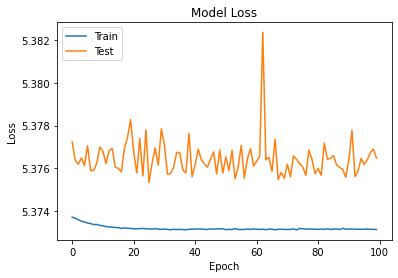

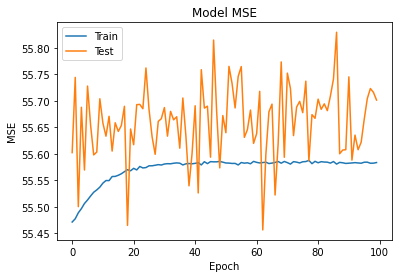

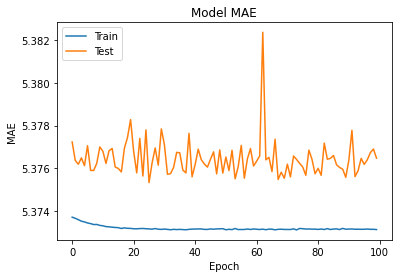

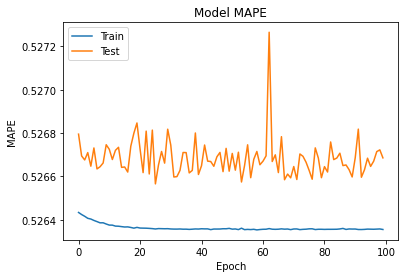

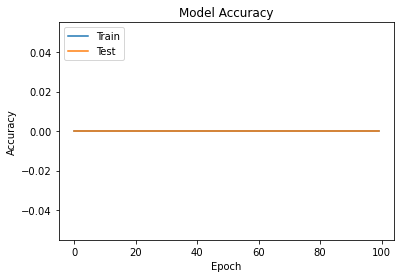

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.title('Model MAPE')
plt.xlabel('Epoch')
plt.ylabel('MAPE')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

In [ ]:
predict = model.evaluate(X_test, y_test)

34706/34706 [==============================] - 37s 1ms/step - loss: 5.3765 - mse: 55.7017 - mae: 5.3765 - mape: 0.5267 - accuracy: 0.0000e+00


**Deep Neural Networks (DNNs) with at least 2 hidden layers.**

In [ ]:
il = tf.keras.layers.Input(shape = (X.shape[1], ), name = 'InputLayer')
h1 = tf.keras.layers.Dense(50, activation = 'relu', name = 'HiddenLayer1')(il)
h2 = tf.keras.layers.Dense(30, activation = 'relu', name = 'HiddenLayer2')(h1)
ol = tf.keras.layers.Dense(1, name = 'OutputLayer')(h2)

In [ ]:
model = tf.keras.Model(inputs = [il], outputs = [ol])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 22)]              0         
                                                                 
 HiddenLayer1 (Dense)        (None, 50)                1150      
                                                                 
 HiddenLayer2 (Dense)        (None, 30)                1530      
                                                                 
 OutputLayer (Dense)         (None, 1)                 31        
                                                                 
Total params: 2,711
Trainable params: 2,711
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.3), loss = 'mae',
              metrics = ['mse', 'mae', 'mape', 'accuracy'])

history = model.fit(X_train, y_train, batch_size = 256, epochs = 10, validation_data = (X_test, y_test),
                    shuffle = True, verbose = True)

Epoch 1/10
17353/17353 [==============================] - 33s 2ms/step - loss: 16.8639 - mse: 6810.8652 - mae: 16.8639 - mape: 1.6518 - accuracy: 0.0000e+00 - val_loss: 7.6486 - val_mse: 254.1024 - val_mae: 7.6486 - val_mape: 0.7477 - val_accuracy: 0.0000e+00
Epoch 2/10
17353/17353 [==============================] - 31s 2ms/step - loss: 9.7355 - mse: 381.6654 - mae: 9.7355 - mape: 0.9536 - accuracy: 0.0000e+00 - val_loss: 6.2609 - val_mse: 158.1913 - val_mae: 6.2609 - val_mape: 0.6125 - val_accuracy: 0.0000e+00
Epoch 3/10
17353/17353 [==============================] - 31s 2ms/step - loss: 3.8947 - mse: 127.1074 - mae: 3.8947 - mape: 0.3814 - accuracy: 0.0000e+00 - val_loss: 2.4779 - val_mse: 27.7839 - val_mae: 2.4779 - val_mape: 0.2427 - val_accuracy: 0.0000e+00
Epoch 4/10
17353/17353 [==============================] - 31s 2ms/step - loss: 3.0840 - mse: 48.5981 - mae: 3.0840 - mape: 0.3020 - accuracy: 0.0000e+00 - val_loss: 2.7327 - val_mse: 24.8870 - val_mae: 2.7327 - val_mape: 0.2676

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mse,mae,mape,accuracy,val_loss,val_mse,val_mae,val_mape,val_accuracy,epoch
0,16.863939,6810.865234,16.863939,1.651751,0.0,7.648551,254.102402,7.648551,0.747740,0.0,0
1,9.735526,381.665405,9.735526,0.953609,0.0,6.260859,158.191345,6.260859,0.612497,0.0,1
2,3.894691,127.107368,3.894691,0.381418,0.0,2.477851,27.783932,2.477851,0.242747,0.0,2
3,3.084040,48.598064,3.084040,0.301961,0.0,2.732672,24.887039,2.732672,0.267566,0.0,3
4,3.085163,35.084934,3.085163,0.302067,0.0,2.261402,17.213360,2.261402,0.221285,0.0,4
5,3.075681,30.030420,3.075681,0.301169,0.0,2.188640,20.764275,2.188640,0.214193,0.0,5
6,3.053530,24.394005,3.053530,0.298948,0.0,2.588129,21.507277,2.588129,0.253248,0.0,6
7,3.163615,26.130932,3.163615,0.309641,0.0,2.516572,20.283236,2.516572,0.246253,0.0,7
8,3.172669,26.080366,3.172669,0.310532,0.0,3.778676,29.871990,3.778676,0.369504,0.0,8
9,3.134776,25.477995,3.134776,0.306815,0.0,2.490906,19.892632,2.490906,0.243674,0.0,9


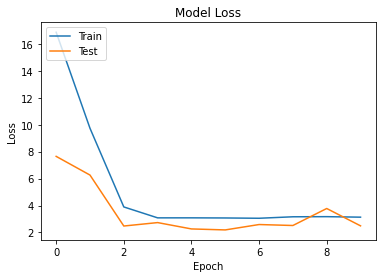

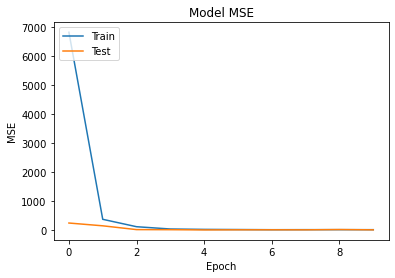

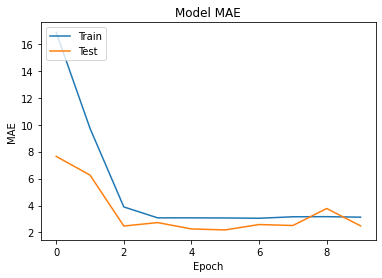

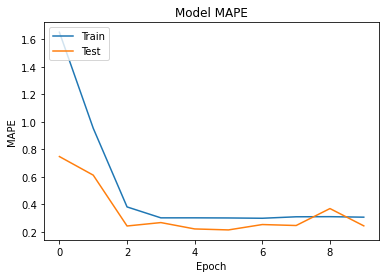

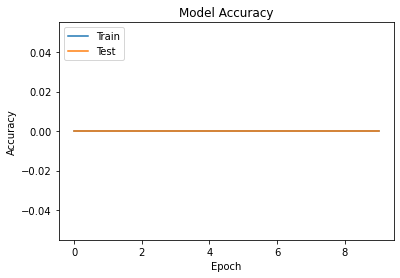

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.title('Model MAPE')
plt.xlabel('Epoch')
plt.ylabel('MAPE')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

In [ ]:
predict = model.evaluate(X_test, y_test)

34706/34706 [==============================] - 43s 1ms/step - loss: 2.4909 - mse: 19.8926 - mae: 2.4909 - mape: 0.2437 - accuracy: 0.0000e+00


In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = 'tbooards/logs/DNNAdam100Epoch', histogram_freq = 1)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1), loss = 'mae',
              metrics = ['mse', 'mae', 'mape', 'accuracy'])

history = model.fit(X_train, y_train, batch_size = 256, epochs = 100, validation_data = (X_test, y_test),
                    shuffle = True, verbose = True, callbacks = [tensorboard_callback])

Epoch 1/100
17353/17353 [==============================] - 36s 2ms/step - loss: 1.8861 - mse: 16.7484 - mae: 1.8861 - mape: 0.1844 - accuracy: 0.0000e+00 - val_loss: 1.9382 - val_mse: 16.6427 - val_mae: 1.9382 - val_mape: 0.1892 - val_accuracy: 0.0000e+00
Epoch 2/100
17353/17353 [==============================] - 32s 2ms/step - loss: 1.8770 - mse: 16.6993 - mae: 1.8770 - mape: 0.1835 - accuracy: 0.0000e+00 - val_loss: 1.7886 - val_mse: 15.9022 - val_mae: 1.7886 - val_mape: 0.1750 - val_accuracy: 0.0000e+00
Epoch 3/100
17353/17353 [==============================] - 32s 2ms/step - loss: 1.8843 - mse: 16.7133 - mae: 1.8843 - mape: 0.1842 - accuracy: 0.0000e+00 - val_loss: 1.5719 - val_mse: 15.5878 - val_mae: 1.5719 - val_mape: 0.1535 - val_accuracy: 0.0000e+00
Epoch 4/100
17353/17353 [==============================] - 32s 2ms/step - loss: 1.8727 - mse: 16.6489 - mae: 1.8727 - mape: 0.1831 - accuracy: 0.0000e+00 - val_loss: 1.7384 - val_mse: 16.3123 - val_mae: 1.7384 - val_mape: 0.1697 - v

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mse,mae,mape,accuracy,val_loss,val_mse,val_mae,val_mape,val_accuracy,epoch
0,1.886141,16.748407,1.886141,0.184393,0.0,1.938195,16.642673,1.938195,0.189241,0.0,0
1,1.877045,16.699291,1.877045,0.183498,0.0,1.788613,15.902165,1.788613,0.174964,0.0,1
2,1.884315,16.713345,1.884315,0.184211,0.0,1.571902,15.587752,1.571902,0.153520,0.0,2
3,1.872691,16.648937,1.872691,0.183069,0.0,1.738374,16.312271,1.738374,0.169726,0.0,3
4,1.878045,16.654572,1.878045,0.183594,0.0,1.766087,15.822343,1.766087,0.172541,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...
95,1.844027,14.875087,1.844027,0.180260,0.0,2.064252,16.027527,2.064252,0.201630,0.0,95
96,1.835605,14.834878,1.835605,0.179433,0.0,1.695371,13.866377,1.695371,0.165770,0.0,96
97,1.849935,14.854562,1.849935,0.180839,0.0,1.820238,14.642448,1.820238,0.177865,0.0,97
98,1.834645,14.783298,1.834645,0.179342,0.0,1.613062,14.158984,1.613062,0.157717,0.0,98


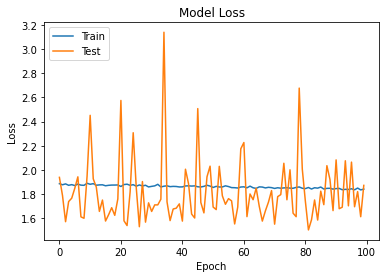

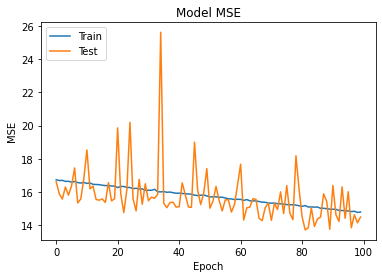

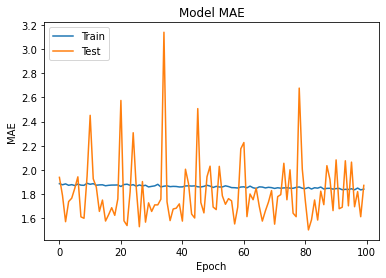

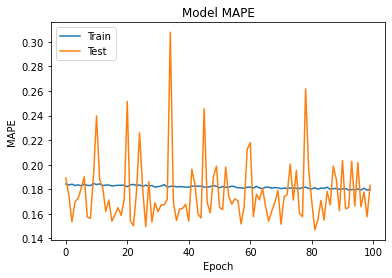

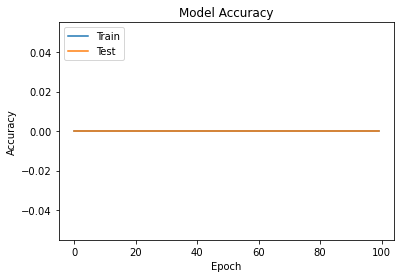

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.title('Model MAPE')
plt.xlabel('Epoch')
plt.ylabel('MAPE')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

In [ ]:
predict = model.evaluate(X_test, y_test)

34706/34706 [==============================] - 38s 1ms/step - loss: 1.8719 - mse: 14.5052 - mae: 1.8719 - mape: 0.1832 - accuracy: 0.0000e+00
